In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Modelling
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Data/loan_train.csv')

In [12]:
df.isna().sum()

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                   0
Credit_History        50
Area                   0
Status                 0
dtype: int64

In [9]:
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
categorical_features = [feature for feature in df.columns if df[feature].dtype=='O']
print(f'We have {len(numerical_features)} numerical features: {numerical_features}')
print(f'We have {len(categorical_features)} Categorical features: {categorical_features}')

We have 6 numerical features: ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Status']
We have 6 Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Area']


In [4]:
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [5]:
status_columns = {
    'Y':1,
    'N':0
}

df['Status'] = df['Status'].map(status_columns)

In [6]:
from sklearn.impute import SimpleImputer

In [14]:
si = SimpleImputer(strategy='most_frequent')
df['Self_Employed'] = si.fit_transform(df[['Self_Employed']])


ValueError: 2

In [30]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

oh = OneHotEncoder(sparse=False)
df['G'] = oh.fit_transform(df[['Gender']])
df.head(5)


/Users/ayushpandey/Desktop/Kaggle /Project-2/myenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,0.0,1.0,0,1.0,1.0,584900,0.0,15000000,360.0,1.0,0.0,1
1,0.0,0.0,1,1.0,1.0,458300,150800.0,12800000,360.0,1.0,1.0,0
2,0.0,0.0,0,1.0,0.0,300000,0.0,6600000,360.0,1.0,0.0,1
3,0.0,0.0,0,0.0,1.0,258300,235800.0,12000000,360.0,1.0,0.0,1
4,0.0,1.0,0,1.0,1.0,600000,0.0,14100000,360.0,1.0,0.0,1


In [49]:
df['Dependents'].replace("3+","3",inplace=True)
df['Dependents'] = df['Dependents'].astype('Int64')


In [50]:
df['Dependents'].value_counts()

Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: Int64

In [32]:
df['Married'].unique()

array([1., 0.])

In [20]:
cols = ['Gender', 'Married', 'Dependents','Self_Employed','Term','Credit_History']
for i in cols:
    df[i] = df[i].fillna(df[i].mode()[0])

In [6]:
labels = [1,0]

In [7]:
df['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']

In [33]:
X = df.drop('Status',axis=1)
y = df['Status']

In [34]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area
0,0.0,1.0,0,1.0,1.0,584900,0.0,15000000,360.0,1.0,0.0
1,0.0,0.0,1,1.0,1.0,458300,150800.0,12800000,360.0,1.0,1.0
2,0.0,0.0,0,1.0,0.0,300000,0.0,6600000,360.0,1.0,0.0
3,0.0,0.0,0,0.0,1.0,258300,235800.0,12000000,360.0,1.0,0.0
4,0.0,1.0,0,1.0,1.0,600000,0.0,14100000,360.0,1.0,0.0


In [35]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_transformaer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',categorical_transformer,cat_features),
        ('StandardScaler',numerical_transformaer,num_features)
    ]
)

In [36]:
X = preprocessor.fit_transform(X)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
def evaluate_function(true,predicted):
    cm = confusion_matrix(true,predicted)
    clr = classification_report(true,predicted)
    accuracy = accuracy_score(true,predicted)
    return cm,clr,accuracy

In [39]:
models = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier()
}

model_list = []
acc_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_cm, model_train_classification_report,model_train_acc = evaluate_function(y_train,y_train_pred)
    model_test_cm, model_test_classification_report,model_test_acc = evaluate_function(y_test,y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    acc_list.append(model_test_acc)

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
XGBClassifier
Learning rate set to 0.007395
0:	learn: 0.6890718	total: 56.9ms	remaining: 56.8s
1:	learn: 0.6850537	total: 57.9ms	remaining: 28.9s
2:	learn: 0.6811845	total: 59.1ms	remaining: 19.7s
3:	learn: 0.6774036	total: 59.7ms	remaining: 14.9s
4:	learn: 0.6731046	total: 60.3ms	remaining: 12s
5:	learn: 0.6691811	total: 60.9ms	remaining: 10.1s
6:	learn: 0.6650973	total: 61.5ms	remaining: 8.73s
7:	learn: 0.6615794	total: 62ms	remaining: 7.68s
8:	learn: 0.6578500	total: 62.6ms	remaining: 6.89s
9:	learn: 0.6542880	total: 63.6ms	remaining: 6.3s
10:	learn: 0.6507750	total: 64.3ms	remaining: 5.78s
11:	learn: 0.6473040	total: 64.9ms	remaining: 5.34s
12:	learn: 0.6437886	total: 65.5ms	remaining: 4.97s
13:	learn: 0.6404661	total: 66.1ms	remaining: 4.66s
14:	learn: 0.6373159	total: 66.8ms	remaining: 4.38s
15:	learn: 0.6341106	total: 67.4ms	remaining: 4.14s
16:	learn: 0.6307084	total: 68ms	remaining: 3.93s
17:	learn: 0.6273824	t

In [40]:
pd.DataFrame(list(zip(model_list, acc_list)), columns=['Model Name', 'Accuracy_Score']).sort_values(by=['Accuracy_Score'], ascending=False)

,Model Name,Accuracy_Score
5,AdaBoostClassifier,0.792208
0,KNeighborsClassifier,0.785714
4,CatBoostClassifier,0.772727
3,XGBClassifier,0.753247
2,RandomForestClassifier,0.746753
1,DecisionTreeClassifier,0.642857


In [41]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
score = accuracy_score(y_test,y_pred)*100
print("Accuracy is %.2f"%score)

Accuracy is 79.22


<Axes: >

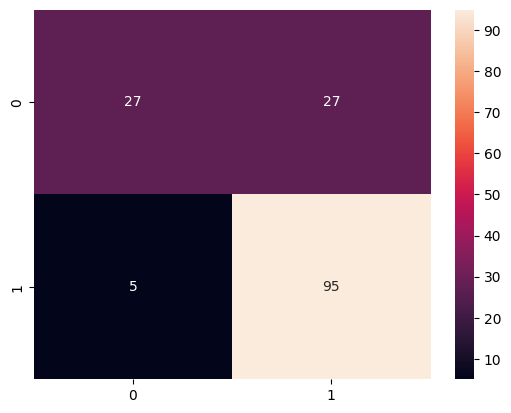

In [42]:
cm = confusion_matrix(y_test,y_pred)
cm
sns.heatmap(cm,annot=True)

In [18]:
df.to_csv('New_Data.csv',index=False,header=True)

In [43]:
df_new = pd.read_csv("Data/New_Data.csv")

In [45]:
df_new.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Term                  0
Credit_History        0
Area                  0
Status                0
Total_Income          0
dtype: int64

In [52]:
df_new['Dependents'] = df_new['Dependents'].replace("3+","3").astype('Int64')

In [57]:
df_new.dtypes

Gender                 object
Married                object
Dependents              Int64
Education              object
Self_Employed          object
Applicant_Income      float64
Coapplicant_Income    float64
Loan_Amount             int64
Term                  float64
Credit_History        float64
Area                   object
Status                  int64
Total_Income          float64
dtype: object

In [55]:
df_new['Applicant_Income'] = df_new['Applicant_Income'].astype("float64")

In [59]:
df_new.drop('Total_Income',inplace=True,axis=1)

In [60]:
df_new.to_csv("New_Data_01.csv",index=False,header=True)

In [19]:
numerical_features = [feature for feature in df_new.columns if df_new[feature].dtype!='O']
categorical_features = [feature for feature in df_new.columns if df_new[feature].dtype=='O']
print(f'We have {len(numerical_features)} numerical features: {numerical_features}')
print(f'We have {len(categorical_features)} Categorical features: {categorical_features}')

We have 8 numerical features: ['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Status', 'Total_Income']
We have 5 Categorical features: ['Gender', 'Married', 'Education', 'Self_Employed', 'Area']


In [3]:
df_new = pd.read_csv("Data/New_Data.csv")

In [8]:
df_new['Dependents'] = df_new['Dependents'].replace("3+","3").astype('int64')

In [14]:
cols_new = ['Gender', 'Married', 'Education', 'Self_Employed', 'Area']

In [17]:
for i in cols_new:
    print(f"{i} has {len(df_new[i].unique())} unique values which are {df_new[i].unique()}")

Gender has 2 unique values which are ['Male' 'Female']
Married has 2 unique values which are ['No' 'Yes']
Education has 2 unique values which are ['Graduate' 'Not Graduate']
Self_Employed has 2 unique values which are ['No' 'Yes']
Area has 3 unique values which are ['Urban' 'Rural' 'Semiurban']


In [18]:
df_new.to_csv("New_Data1.csv",index=False,header=True)